In [1]:
import os
from osgeo import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
!ls

In [3]:
images_path = 'v1_test_source_s2/'
labels_path = 'v1_test_labels/'

images_files = os.listdir('v1_test_source_s2/')
labels_files = os.listdir('v1_test_labels/')

In [4]:
images_files_info = []

for file in tqdm(images_files):
    if file[:3] == 'ref':
        images_files_info.append([images_path+file+'/', file[53:57], 
                                  pd.to_datetime(file[-10:-6] + '.' + file[-5:-3] + '.' + file[-2:])])
    else:
        print(file)

train_images = pd.DataFrame(images_files_info, columns=['path', 'id', 'date'])

labels_files_info = []

for file in tqdm(labels_files):
    if file[:3] == 'ref':
        labels_files_info.append([labels_path+file+'/', file[-4:]])
    else:
        print(file)

train_labels = pd.DataFrame(labels_files_info, columns=['path', 'id'])

 81%|███████████████████████████▌      | 49948/61726 [00:02<00:00, 23742.30it/s]

collection.json


100%|██████████████████████████████████| 1138/1138 [00:00<00:00, 1260395.55it/s]

.DS_Store


In [5]:
train_images.id = train_images.id.astype(int)
train_labels.id = train_labels.id.astype(int)

In [6]:
train_images.shape

(61725, 3)

In [7]:
train_images.groupby('id').count().groupby('path').count()

,date
path,
38,636
39,2
40,3
47,4
49,2
51,1
52,1
54,1
56,2


In [8]:
train_labels

,path,id
0,v1_test_labels/ref_south_africa_crops_competit...,590
1,v1_test_labels/ref_south_africa_crops_competit...,1026
2,v1_test_labels/ref_south_africa_crops_competit...,100
3,v1_test_labels/ref_south_africa_crops_competit...,332
4,v1_test_labels/ref_south_africa_crops_competit...,756
...,...,...
1132,v1_test_labels/ref_south_africa_crops_competit...,376
1133,v1_test_labels/ref_south_africa_crops_competit...,1062
1134,v1_test_labels/ref_south_africa_crops_competit...,382
1135,v1_test_labels/ref_south_africa_crops_competit...,349


In [9]:
train_labels.groupby('id').count().sort_values('path')

,path
id,
1,1
749,1
750,1
751,1
752,1
...,...
377,1
376,1
375,1


In [10]:
fields_labels_on_image = []

for i, val in tqdm(train_labels.iterrows()):
    
    field_ids = gdal.Open(val['path']+'field_ids.tif').ReadAsArray()
    
    ids = np.unique(field_ids)
    ids = ids[ids != 0]
    
    for idx in ids:

        fields_labels_on_image.append([val['id'], idx])

fields_labels_on_image = pd.DataFrame(fields_labels_on_image, 
                                      columns=['id', 'field_id'])

1137it [00:01, 799.37it/s]


In [11]:
fields_labels_on_image

,id,field_id
0,590,1825
1,590,3079
2,590,3848
3,590,28857
4,590,33478
...,...,...
35290,947,95767
35291,947,101421
35292,947,105889
35293,947,115157


In [12]:
train_labels = pd.merge(fields_labels_on_image, train_labels, on=['id'], how='left')

In [13]:
train_labels = train_labels.reset_index(drop=True)

In [14]:
img1 = train_images[train_images.id == 1].path.values
lab1 = train_labels[train_labels.id == 1].path.values[0]

In [15]:
b08 = gdal.Open(img1[2]+'B08.tif').ReadAsArray() / 255.
b04 = gdal.Open(img1[2]+'B04.tif').ReadAsArray() / 255.

In [16]:
field_ids = gdal.Open(lab1+'field_ids.tif').ReadAsArray()
# labels = gdal.Open(lab1+'labels.tif').ReadAsArray()

In [17]:
!ls v1_train_source_s2/ref_south_africa_crops_competition_v1_train_source_s2_0001_2017_09_11/

B01.tif   B03.tif   B05.tif   B07.tif   B09.tif   B12.tif   CLM.tif
B02.tif   B04.tif   B06.tif   B08.tif   B11.tif   B8A.tif   stac.json


In [18]:
!ls v1_train_labels/ref_south_africa_crops_competition_v1_train_labels_0001/

field_ids.tif labels.tif    stac.json


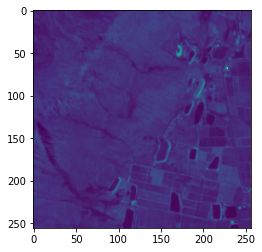

In [19]:
plt.imshow(b04)

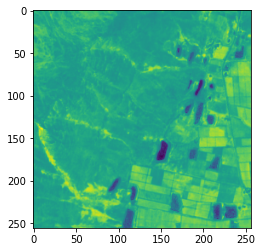

In [20]:
ndvi = np.zeros((256, 256))
np.divide((b08 - b04), (b08+b04), out=ndvi, where=(b08+b04)!=0)

plt.imshow(ndvi)

In [21]:
ndvi

array([[0.39240506, 0.43661972, 0.44117647, ..., 0.31578947, 0.28947368,
        0.2987013 ],
       [0.34246575, 0.41176471, 0.44615385, ..., 0.30120482, 0.28395062,
        0.275     ],
       [0.36363636, 0.40625   , 0.42857143, ..., 0.2967033 , 0.28089888,
        0.26666667],
       ...,
       [0.26436782, 0.26436782, 0.23809524, ..., 0.62162162, 0.6146789 ,
        0.62831858],
       [0.23809524, 0.22891566, 0.24390244, ..., 0.62068966, 0.6146789 ,
        0.64285714],
       [0.22352941, 0.26190476, 0.25581395, ..., 0.59349593, 0.56140351,
        0.57522124]])

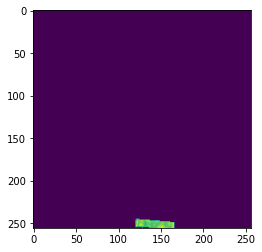

In [22]:
plt.imshow(np.where(field_ids==np.unique(field_ids)[1], ndvi, 0))

In [23]:
n = np.where(field_ids==np.unique(field_ids)[1], ndvi, 0)
n = n[n != 0]

In [24]:
ndvi[np.where(field_ids==np.unique(field_ids)[1])].mean()

0.5006427302538612

In [25]:
np.unique(field_ids)[1]

2199

In [26]:
n.mean()

0.5006427302538612

In [27]:
np.percentile(ndvi[np.where(field_ids==np.unique(field_ids)[1])], 0.5)

0.3124203737825743

In [28]:
np.unique(field_ids)

array([     0,   2199,   2277,   2571,   3112,   7476,   7680,   9012,
        10037,  10746,  10850,  11058,  15409,  18539,  20697,  20785,
        21397,  22202,  26024,  29605,  29626,  33028,  35966,  37593,
        37998,  38318,  39708,  42152,  42634,  44139,  45166,  45197,
        45238,  46082,  46735,  47435,  50881,  51663,  51848,  52126,
        55278,  55349,  60755,  60996,  62813,  63604,  63738,  64441,
        64909,  70512,  70777,  72041,  76043,  76657,  77589,  77620,
        78363,  81150,  82299,  82415,  85647,  87327,  87341,  91210,
        91864,  92380,  93306,  97012, 100081, 101103, 103547, 106483,
       107027, 107078, 107102, 109712, 110829, 111474, 113122, 113347,
       113423, 118369, 118412, 119785], dtype=uint32)

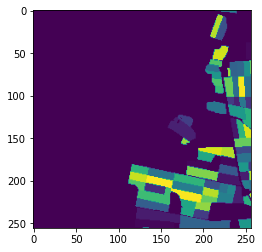

In [29]:
plt.imshow(field_ids)

In [31]:
# NDVI
def ndvi_calc(B8A, B04):
    ndvi = np.zeros((256, 256))
    np.divide((B8A - B04), (B8A+B04), out=ndvi, where=(B8A+B04)!=0)
    return ndvi

# SOIL ADJUSTED VEGETATION INDEX, SAVI
def savi_calc(B8A, B04):
    savi = np.zeros((256, 256))
    np.divide(1.5*(B8A-B04), (B8A+B04+0.5), out=savi, where=(B8A+B04+0.5)!=0)
    return savi

# ATMOSPHERICALLY RESISTANT VEGETATION INDEX, ARVI
def arvi_calc(B08, B04, B02):
    arvi = np.zeros((256, 256))
    np.divide((B08-(B04-1*(B02-B04))), (B08+(B04-1*(B02-B04))), out=arvi, where=(B08+(B04-1*(B02-B04)))!=0)
    return arvi
    

# EVI - интенсивный индекс растительности
def evi_calc(B8A, B04, B02):
    evi = np.zeros((256, 256))
    np.divide(2.5*(B8A-B04), ((B8A+6*B04-7.5*B02)+1), out=evi, where=((B8A+6*B04-7.5*B02)+1)!=0)
    return evi

# GCI - хлорофил
def gci_calc(B08, B03):
    gci = np.zeros((256, 256))
    np.divide(B08, B03, out=gci, where=B03!=0)
    return gci-1

# SIPI
def sipi_calc(B08, B02, B04):
    sipi = np.zeros((256, 256))
    np.divide((B08-B02), (B08-B04), out=sipi, where=(B08-B04)!=0)
    return sipi

# NBR
def nbr_calc(B8A, B12):
    nbr = np.zeros((256, 256))
    np.divide((B8A-B12), (B8A+B12), out=nbr, where=(B8A+B12)!=0)
    return nbr

# NDWI
def ndwi_calc(B03, B08):
    ndwi = np.zeros((256, 256))
    np.divide((B03-B08), (B03+B08), out=ndwi, where=(B03+B08)!=0)
    return ndwi

# NDSI > 0.4 - снег
def ndsi_calc(B03, B11):
    ndsi = np.zeros((256, 256))
    np.divide((B03-B11), (B03+B11), out=ndsi, where=(B03+B11)!=0)
    return ndsi

# DEFORESTATION INDEX
def deforest_calc(B03, B09, B11, B12):
    return (B03+B09)*(B11+B12)

# FIRE DETECTION INDEX
def fire_calc(B12, B8A, B09):
    fire = np.zeros((256, 256))
    np.divide(B12, (B8A*B09), out=fire, where=(B8A*B09)!=0)
    return fire

In [32]:
train_labels.head(1)

,id,field_id,path
0,590,1825,v1_test_labels/ref_south_africa_crops_competit...


In [33]:
train_images.id.unique()

array([726, 762, 610, ..., 780,  36, 283])

In [34]:
train_images[train_images.id == 1]

,path,id,date
818,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-05-01
1279,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-06-10
2586,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-11-07
4250,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-05-31
5626,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-06-20
9515,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-07-20
10104,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-10-08
10538,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-08-04
12450,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-04-01
12864,v1_test_source_s2/ref_south_africa_crops_compe...,1,2017-07-10


In [35]:
part1 = train_images.id.unique()

columns = ['id', 'date', 'field_id']
for indx in ['ndvi', 'savi', 'arvi', 'evi', 'gci', 'sipi', 'nbr', 'ndwi', 'deforest',
             'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12']:
    
    for post in ['mean', 'median']:
        columns.append(indx+'_'+post)

In [36]:
result = []

for image_id in tqdm(part1):
    
    temp_train_images = train_images[train_images.id == image_id]

    for j in range(temp_train_images.shape[0]):
        
        path_to_image = temp_train_images.path.values[j]
        image_date = temp_train_images.date.values[j]
        
        B01 = gdal.Open(path_to_image+'B01.tif').ReadAsArray() / 255.
        B02 = gdal.Open(path_to_image+'B02.tif').ReadAsArray() / 255.
        B03 = gdal.Open(path_to_image+'B03.tif').ReadAsArray() / 255.
        B04 = gdal.Open(path_to_image+'B04.tif').ReadAsArray() / 255.
        B05 = gdal.Open(path_to_image+'B05.tif').ReadAsArray() / 255.
        B06 = gdal.Open(path_to_image+'B06.tif').ReadAsArray() / 255.
        B07 = gdal.Open(path_to_image+'B07.tif').ReadAsArray() / 255.
        B08 = gdal.Open(path_to_image+'B08.tif').ReadAsArray() / 255.
        B8A = gdal.Open(path_to_image+'B8A.tif').ReadAsArray() / 255.
        B09 = gdal.Open(path_to_image+'B09.tif').ReadAsArray() / 255.
        B11 = gdal.Open(path_to_image+'B11.tif').ReadAsArray() / 255.
        B12 = gdal.Open(path_to_image+'B12.tif').ReadAsArray() / 255.
        
        ndvi = ndvi_calc(B8A, B04)
        savi = savi_calc(B8A, B04)
        arvi = arvi_calc(B08, B04, B02)
        evi = evi_calc(B8A, B04, B02)
        gci = gci_calc(B08, B03)
        sipi = sipi_calc(B08, B02, B04)
        nbr = nbr_calc(B8A, B12)
        ndwi = ndwi_calc(B03, B08)
        deforest = deforest_calc(B03, B09, B11, B12)
    
        temp_train_labels = train_labels[train_labels.id == image_id]
        
        for i in range(temp_train_labels.shape[0]):
    
            field_id = temp_train_labels.field_id.values[i]
#             label = temp_train_labels.label.values[i]
    
            field_ids = gdal.Open(temp_train_labels.path.values[i]+'field_ids.tif').ReadAsArray()
        
            temp_result = [image_id, image_date, field_id]
            
            for indx in [ndvi, savi, arvi, evi, gci, sipi, nbr, ndwi, deforest,
                         B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]:
                
                res_mean = indx[np.where(field_ids==field_id)].mean()
                res_median = np.median(ndvi[np.where(field_ids==field_id)])
                
                temp_result.append(res_mean)
                temp_result.append(res_median)
            
            result.append(temp_result)

res = pd.DataFrame(result, columns=columns)
res.to_csv('test.csv', index=False)

100%|█████████████████████████████████████| 1137/1137 [4:31:01<00:00, 14.30s/it]


In [37]:
res

,id,date,field_id,ndvi_mean,ndvi_median,savi_mean,savi_median,arvi_mean,arvi_median,evi_mean,...,B08_mean,B08_median,B8A_mean,B8A_median,B09_mean,B09_median,B11_mean,B11_median,B12_mean,B12_median
0,726,2017-07-25,1518,-0.033208,-0.071641,-0.037136,-0.071641,0.097800,-0.071641,-2.377466e+11,...,0.792217,-0.071641,0.714908,-0.071641,0.998661,-0.071641,0.516308,-0.071641,0.384796,-0.071641
1,726,2017-07-25,1993,-0.024055,-0.055417,-0.026717,-0.055417,0.081945,-0.055417,2.914940e-01,...,0.740807,-0.055417,0.691173,-0.055417,0.999498,-0.055417,0.471037,-0.055417,0.348069,-0.055417
2,726,2017-07-25,6538,-0.026679,-0.053401,-0.030832,-0.053401,0.052477,-0.053401,6.074065e-01,...,0.856916,-0.053401,0.827408,-0.053401,1.000000,-0.053401,0.529658,-0.053401,0.401779,-0.053401
3,726,2017-07-25,15075,-0.015396,-0.065466,-0.016119,-0.065466,0.102978,-0.065466,7.630116e+11,...,0.626078,-0.065466,0.557062,-0.065466,0.810897,-0.065466,0.471926,-0.065466,0.365826,-0.065466
4,726,2017-07-25,43095,-0.008534,-0.056678,-0.008868,-0.056678,0.101562,-0.056678,2.005676e-02,...,0.579319,-0.056678,0.514844,-0.056678,0.739596,-0.056678,0.473172,-0.056678,0.390669,-0.056678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1744549,283,2017-11-20,105745,0.089576,0.044475,0.077100,0.044475,-0.109784,0.044475,7.495096e-02,...,0.370331,0.044475,0.374790,0.044475,0.375373,0.044475,0.480159,0.044475,0.415546,0.044475
1744550,283,2017-11-10,31855,0.127226,0.047788,0.100391,0.047788,-0.119695,0.047788,8.391976e-02,...,0.324556,0.047788,0.324090,0.047788,0.292344,0.047788,0.458730,0.047788,0.414472,0.047788
1744551,283,2017-11-10,81124,0.134270,0.048512,0.105178,0.048512,-0.124415,0.048512,8.793807e-02,...,0.316929,0.048512,0.322839,0.048512,0.318034,0.048512,0.472908,0.048512,0.425739,0.048512
1744552,283,2017-11-10,97450,0.086399,0.031876,0.073998,0.031876,-0.170573,0.031876,5.851312e-02,...,0.363411,0.031876,0.362699,0.031876,0.362617,0.031876,0.484177,0.031876,0.435185,0.031876
